In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import requests

In [2]:
fname = 'kn_scores_kndetect_both_models.parquet'

In [3]:
data = pd.read_parquet(fname)

In [4]:
data.shape

(2350, 10)

In [5]:
sum(data['knscore_complete'] > 0.5)

1637

In [6]:
sum(data['knscore_partial'] > 0.5)

400

In [7]:
sum(data['rf_kn_vs_nonkn']>0.5)

251

In [8]:
from fink_utils.photometry.conversion import mag2fluxcal_snana
from kndetect.utils import load_pcs
from kndetect.predict import load_classifier, predict_kn_score
from kndetect.features import extract_features_all_lightcurves, get_feature_names, calc_prediction

model = load_classifier("partial.pkl")
pcs = load_pcs()
filters = ['g', 'r']

new_model_scores = []
predicted_features = []

for indx, row in data.iterrows():
    #indx = list(data['candid'].values).index(lcs_complete.iloc[pos]['candid'])
    flag = np.array([str(data['cmagpsf'].iloc[indx][i]) != 'nan' for i in range(data['cmagpsf'].iloc[indx].shape[0])])
    
    mag = data.iloc[indx]['cmagpsf'][flag]
    magerr = data.iloc[indx]['csigmapsf'][flag]

    flux_data = [mag2fluxcal_snana(*args) for args in zip(
        mag,
        magerr)]
    flux, error = np.transpose(flux_data)

    lc = {}
    lc['SNID'] = indx
    lc['MJD'] = data.iloc[indx]['cjd'][flag]
    lc['FLT'] = pd.Series(data.iloc[indx]['cfid'][flag])
    lc['FLT'].replace({1: 'g', 2: 'r'}, inplace=True)

    lc['FLUXCAL'] = flux
    lc['FLUXCALERR'] = error

    pdf = pd.DataFrame.from_dict(lc)
    features_df = extract_features_all_lightcurves(pdf, key="SNID", pcs=pcs, filters=filters)
    features = features_df.iloc[0].values
    predicted_features.append(features)

    probabilities_, _ = predict_kn_score(clf=model, features_df=features_df);
    #print(probabilities_.T[1])
    new_model_scores.extend(probabilities_.T[1])


100%|██████████| 1/1 [00:00<00:00, 35.24it/s]


In [9]:
get_feature_names()

['coeff1_g',
 'coeff2_g',
 'coeff3_g',
 'residuo_g',
 'maxflux_g',
 'coeff1_r',
 'coeff2_r',
 'coeff3_r',
 'residuo_r',
 'maxflux_r']

In [10]:
data["new_model_scores"] = new_model_scores
data["new_model_features"] = predicted_features

In [11]:
print("Number of events classified KN with new model: "+str(np.sum(np.array(new_model_scores)>=0.5)))

Number of events classified KN with new model: 196


In [12]:
print("Number of events in common with old model: "+str(np.sum((np.array(new_model_scores)>=0.5) & (data['rf_kn_vs_nonkn']>0.5))))

Number of events in common with old model: 90


Text(0, 0.5, 'N')

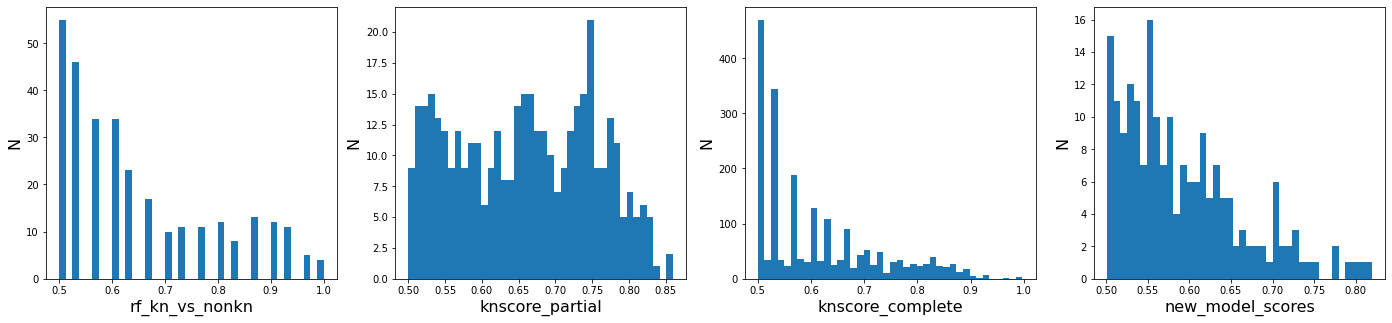

In [13]:
plt.figure(figsize=(24,5))

plt.subplot(1,4,1)
plt.hist(data['rf_kn_vs_nonkn'][data['rf_kn_vs_nonkn'] >= 0.5], bins=40)
plt.xlabel('rf_kn_vs_nonkn', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.subplot(1,4,2)
plt.hist(data['knscore_partial'][data['knscore_partial'] >= 0.5], bins=40)
plt.xlabel('knscore_partial', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.subplot(1,4,3)
plt.hist(data['knscore_complete'][data['knscore_complete'] >= 0.5], bins=40)
plt.xlabel('knscore_complete', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.subplot(1,4,4)
plt.hist(data['new_model_scores'][data['new_model_scores'] >= 0.5], bins=40)
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('N', fontsize=16)


Text(0, 0.5, 'rf_kn_vs_nonkn')

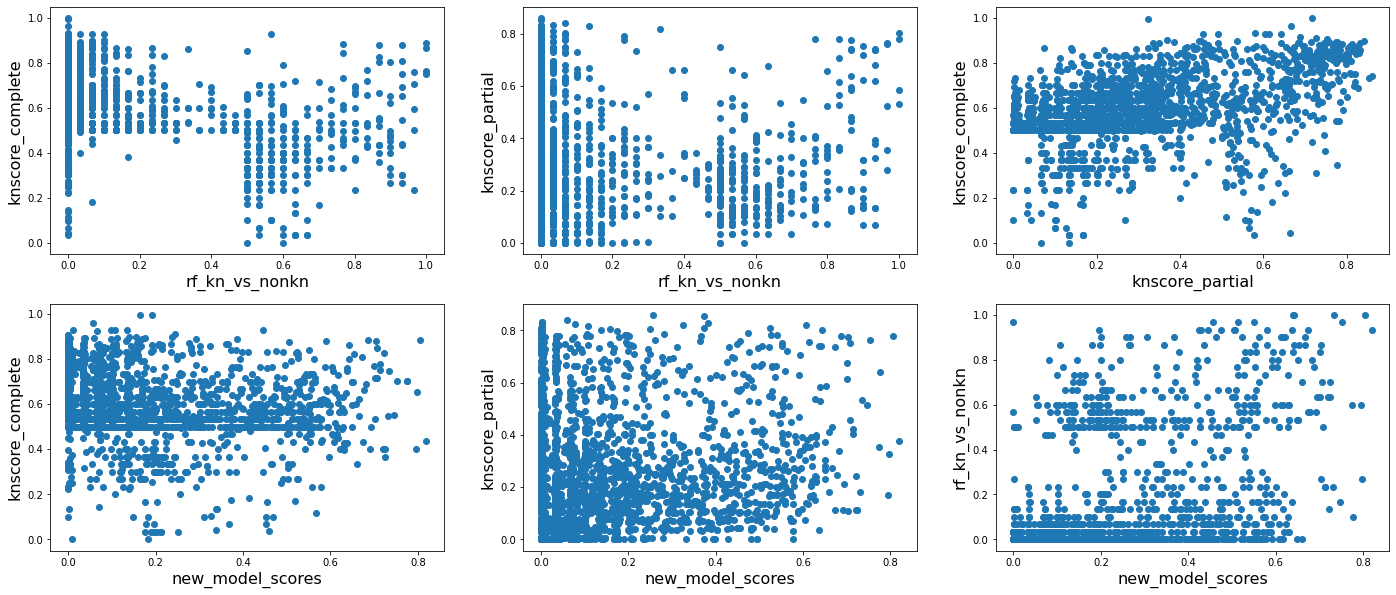

In [14]:
plt.figure(figsize=(24,10))

plt.subplot(2,3,1)
plt.scatter(data['rf_kn_vs_nonkn'], data['knscore_complete'])
plt.xlabel('rf_kn_vs_nonkn', fontsize=16)
plt.ylabel('knscore_complete', fontsize=16)

plt.subplot(2,3,2)
plt.scatter(data['rf_kn_vs_nonkn'], data['knscore_partial'])
plt.xlabel('rf_kn_vs_nonkn', fontsize=16)
plt.ylabel('knscore_partial', fontsize=16)

plt.subplot(2,3,3)
plt.scatter(data['knscore_partial'], data['knscore_complete'])
plt.xlabel('knscore_partial', fontsize=16)
plt.ylabel('knscore_complete', fontsize=16)

plt.subplot(2,3,4)
plt.scatter(data['new_model_scores'], data['knscore_complete'])
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('knscore_complete', fontsize=16)

plt.subplot(2,3,5)
plt.scatter(data['new_model_scores'], data['knscore_partial'])
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('knscore_partial', fontsize=16)

plt.subplot(2,3,6)
plt.scatter(data['new_model_scores'], data['rf_kn_vs_nonkn'])
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('rf_kn_vs_nonkn', fontsize=16)

#plt.savefig('plots/scatter_scores.png')

In [15]:
lcs_complete = data[data['new_model_scores'] >= 0.5]

In [16]:
lcs_complete.shape

(196, 12)

In [17]:
ids = list(data['objectId'].values)

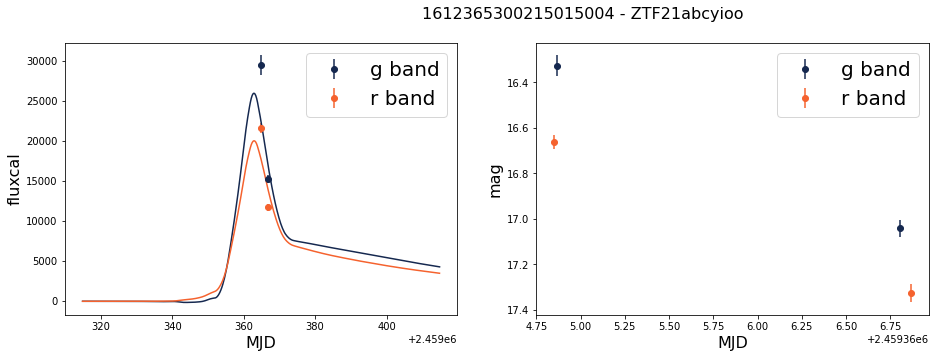

In [18]:
for pos in range(lcs_complete.shape[0]):
    indx = list(data['candid'].values).index(lcs_complete.iloc[pos]['candid'])
    flag = np.array([str(data['cmagpsf'].iloc[indx][i]) != 'nan' for i in range(data['cmagpsf'].iloc[indx].shape[0])])
    # print(lcs_complete.iloc[pos]['candid'])
    mag = data.iloc[indx]['cmagpsf'][flag]
    magerr = data.iloc[indx]['csigmapsf'][flag]
    if pos != 4:
        continue

    flux_data = [mag2fluxcal_snana(*args) for args in zip(
        mag,
        magerr)]
    flux, error = np.transpose(flux_data)

    lc = {}
    lc['SNID'] = indx
    lc['MJD'] = data.iloc[indx]['cjd'][flag]
    lc['FLT'] = pd.Series(data.iloc[indx]['cfid'][flag])
    #lc['FLT'].replace({1: 'g', 2: 'r'}, inplace=True)

    lc['FLUXCAL'] = flux
    lc['FLUXCALERR'] = error
    
    lc['mag'] = data.iloc[indx]['cmagpsf'][flag]
    lc['magerr'] = data.iloc[indx]['csigmapsf'][flag]
    
    lc = pd.DataFrame(lc)
    
    features = data.iloc[indx]['new_model_features']


    plt.figure(figsize=(16,5))
    plt.suptitle(str(data['candid'].iloc[indx]) + ' - ' + str(data['objectId'].iloc[indx]), fontsize=16)

    ax = plt.subplot(1,2,1)
    plt.errorbar(lc['MJD'][lc['FLT'] == 1], lc['FLUXCAL'][lc['FLT'] == 1], yerr=lc['FLUXCALERR'][lc['FLT'] == 1], c='#15284F', fmt='o', label="g band")
    plt.errorbar(lc['MJD'][lc['FLT'] == 2], lc['FLUXCAL'][lc['FLT'] == 2], yerr=lc['FLUXCALERR'][lc['FLT'] == 2], c='#F5622E', fmt='o', label="r band")
    
    g_pred = calc_prediction(pcs, features[:3])*features[4]
    g_band_data = lc[lc['FLT'] == 1]
    max_loc = np.argmax(g_band_data['FLUXCAL'])
    max_flux_date_g = g_band_data.iloc[max_loc]['MJD']
    
    dates_g = np.arange(-50, 50.25, .25) + max_flux_date_g
    plt.plot(dates_g, g_pred, c='#15284F')
    
    r_pred = calc_prediction(pcs, features[5:8])*features[9]
    r_band_data = lc[lc['FLT'] == 2]
    max_loc = np.argmax(r_band_data['FLUXCAL'])
    max_flux_date_r = r_band_data.iloc[max_loc]['MJD']
    
    dates_r = np.arange(-50, 50.25, .25) + max_flux_date_r
    plt.plot(dates_r, r_pred, c='#F5622E')
    
    
    #plt.plot(g_pred)
    
    
    #predicted_g = clac_prediction()
    plt.xlabel('MJD', fontsize=16)
    plt.ylabel('fluxcal', fontsize=16)
    
    plt.legend(fontsize=20)

    ax=plt.subplot(1,2,2)
    plt.errorbar(lc['MJD'][lc['FLT'] == 1], lc['mag'][lc['FLT'] == 1], yerr=lc['magerr'][lc['FLT'] == 1], c='#15284F', fmt='o', label="g band")
    plt.errorbar(lc['MJD'][lc['FLT'] == 2], lc['mag'][lc['FLT'] == 2], yerr=lc['magerr'][lc['FLT'] == 2], c='#F5622E', fmt='o', label="r band")
    plt.xlabel('MJD', fontsize=16)
    plt.ylabel('mag', fontsize=16)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.legend(fontsize=20)

#     plt.scatter([], [], label='knscore_complete = ' + str(round(data['knscore_complete'].iloc[indx], 2)), color='white')
#     plt.scatter([], [], label='knscore_partial = ' + str(round(data['knscore_partial'].iloc[indx],2)), color='white')
#     plt.scatter([], [], label='rf_kn_vs_nonkn = ' + str(round(data['rf_kn_vs_nonkn'].iloc[indx], 2)), color='white')
#     plt.scatter([], [], label='new_model_score = ' + str(round(data['new_model_scores'].iloc[indx], 2)), color='white')
#     plt.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.01,0.95))
    
    plt.subplots_adjust(left=0.05, right=0.8)
    
    plt.show()

    #plt.savefig('plots/' + str(data['candid'].iloc[indx]) + '.png')

## 